# Test Ben forward solver

In [1]:
import jax
import jax.numpy as jnp

In [31]:
def acoustic2D(velocity,
               density,
               source_i,
               f0,
               dx, dy, dt,
               n_steps,
               receiver_is=None,
               output_wavefield=True,
               ):
    """Simulate seismic waves through a 2D velocity model"""

    assert density.shape == velocity.shape
    nx, ny = velocity.shape

    # precompute some arrays
    pressure_present = jnp.zeros_like(velocity)
    pressure_past = jnp.zeros_like(velocity)
    kappa = density*(velocity**2)
    density_half_x = jnp.pad(0.5 * (density[1:nx,:]+density[:nx-1,:]), [[0,1],[0,0]], mode="edge")
    density_half_y = jnp.pad(0.5 * (density[:,1:ny]+density[:,:ny-1]), [[0,0],[0,1]], mode="edge")
    t0 = 1.2 / f0
    factor = 1e4
    v_source = velocity[source_i[0], source_i[1]]

    # TODO: add absorbing boundary

    def step(carry, it):
        pressure_past, pressure_present = carry

        t = it*dt

        # compute the first spatial derivatives divided by density
        pressure_x = jnp.pad((pressure_present[1:nx,:]-pressure_present[:nx-1,:]) / dx, [[0,1],[0,0]], mode="constant", constant_values=0.)
        pressure_y = jnp.pad((pressure_present[:,1:ny]-pressure_present[:,:ny-1]) / dy, [[0,0],[0,1]], mode="constant", constant_values=0.)
        pressure_density_x = pressure_x / density_half_x
        pressure_density_y = pressure_y / density_half_y

        # compute the second spatial derivatives
        pressure_xx = jnp.pad((pressure_density_x[1:nx,:]-pressure_density_x[:nx-1,:]) / dx, [[1,0],[0,0]], mode="constant", constant_values=0.)
        pressure_yy = jnp.pad((pressure_density_y[:,1:ny]-pressure_density_y[:,:ny-1]) / dy, [[0,0],[1,0]], mode="constant", constant_values=0.)

        # advance wavefield
        pressure_future = - pressure_past \
                          + 2 * pressure_present \
                          + dt*dt*(pressure_xx+pressure_yy)*kappa

        # add the source
        # Ricker source time function (second derivative of a Gaussian)
        a = (jnp.pi**2)*f0*f0
        source_term = factor * (1 - 2*a*(t-t0)**2)*jnp.exp(-a*(t-t0)**2)
        pressure_future = pressure_future.at[source_i[0], source_i[1]].add(
            dt*dt*(4*jnp.pi*(v_source**2)*source_term))# latest seismicCPML normalisation

        # extract outputs
        y = []
        if receiver_is is not None:
            gather = pressure_future[receiver_is[:,0], receiver_is[:,1]]
            y.append(gather)
        if output_wavefield:
            y.append(pressure_future)

        # move new values to old values (the present becomes the past, the future becomes the present)
        return (pressure_present, pressure_future), y

    _, y = jax.lax.scan(step, (pressure_past, pressure_present), jnp.arange(n_steps))

    return y

def acoustic2D_pml(velocity,
                   density,
                   source_i,
                   f0,
                   dx, dy, dt,
                   n_steps,
                   receiver_is=None,
                   output_wavefield=True,
                   pml_width=20,
                   R_coeff=1e-3):
    """2D acoustic FD with a simple PML/sponge absorbing boundary,
       and the Ricker source scaled per seismicCPML normalization."""
    nx, ny = velocity.shape
    assert density.shape == velocity.shape

    # time levels
    pressure_past    = jnp.zeros_like(velocity)
    pressure_present = jnp.zeros_like(velocity)

    # bulk modulus and half-cell densities
    kappa      = density * (velocity**2)
    rho_x_half = jnp.pad(0.5*(density[1:,:] + density[:-1,:]), [[0,1],[0,0]], mode="edge")
    rho_y_half = jnp.pad(0.5*(density[:,1:] + density[:,:-1]), [[0,0],[0,1]], mode="edge")

    # Ricker source parameters
    t0     = 1.2 / f0
    factor = 1e4
    v_source = velocity[source_i[0], source_i[1]]

    # build PML damping profile
    sigma_max = -(3.0 * velocity.max() * jnp.log(R_coeff)) / (2.0 * pml_width * dx)
    def make_sigma(n, npml):
        i = jnp.arange(n)
        left  = jnp.where(i < npml,       (npml - i) / npml, 0.0)
        right = jnp.where(i >= n - npml, (i - (n-npml-1)) / npml, 0.0)
        return sigma_max * (left**2 + right**2)
    σx = make_sigma(nx, pml_width)
    σy = make_sigma(ny, pml_width)
    sigma2d = jnp.add.outer(σx, σy)

    def step(carry, it):
        p_nm1, p_n = carry
        t = it * dt

        # spatial gradients -> laplacian
        dp_dx = jnp.pad((p_n[1:,:] - p_n[:-1,:]) / dx, [[0,1],[0,0]], 'constant')
        dp_dy = jnp.pad((p_n[:,1:] - p_n[:,:-1]) / dy, [[0,0],[0,1]], 'constant')
        dp_dx /= rho_x_half
        dp_dy /= rho_y_half
        d2p_dx2 = jnp.pad((dp_dx[1:,:] - dp_dx[:-1,:]) / dx, [[1,0],[0,0]], 'constant')
        d2p_dy2 = jnp.pad((dp_dy[:,1:] - dp_dy[:,:-1]) / dy, [[0,0],[1,0]], 'constant')

        # Ricker source term
        t_source = t*4.5
        a = (jnp.pi**2) * f0**2
        ricker = factor * (1 - 2*a*(t_source - t0)**2) * jnp.exp(-a*(t_source - t0)**2)

        # PML damping coefficient beta
        β = sigma2d * dt / 2.0

        # finite-difference update with damping
        lap = dt*dt * (d2p_dx2 + d2p_dy2) * kappa
        p_np1 = (lap + 2*p_n - (1 - β)*p_nm1) / (1 + β)

        # inject scaled source per seismicCPML
        source_term = dt*dt * (4*jnp.pi*(v_source**2) * ricker)
        p_np1 = p_np1.at[source_i[0], source_i[1]].add(source_term)

        # collect outputs
        out = []
        if receiver_is is not None:
            out.append(p_np1[receiver_is[:,0], receiver_is[:,1]])
        if output_wavefield:
            out.append(p_np1)

        return (p_n, p_np1), out

    (_, _), ys = jax.lax.scan(step,
                          (pressure_past, pressure_present),
                          jnp.arange(n_steps))
    return ys

def print_stable_simulation_parameters(velocity, f=20, dt=0.0001):

    # The Nyquist rate is twice the maximum component frequency of the function being sampled

    # CONSTRAINTS:
    #
    # 1) we want to avoid aliasing the wave in time and space:
    #
    #   dt  <<  T/2 = 1/(2f)
    #   dx  <<  L/2 = min(v)/(2f)
    #
    # 2) we want to make sure a point doesn't "leave" a grid cell in a single timestep
    # (i.e. courant number << 1 https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition)
    #
    #   dx  >>  max(v)*dt

    print("Velocity max/min: %.2f, %.2f"%(jnp.min(velocity), jnp.max(velocity)))

    dt_f = 1/(2*f)
    dx_f = jnp.min(velocity)/(2*f)

    print("For nyquist stable (%.2f Hz), choose dx << %s"%(f, dx_f))
    print("For nyquist stable (%.2f Hz), choose dt << %s"%(f, dt_f))

    dx_c = jnp.max(velocity)*dt

    print("Assuming dt=%.5f, for courant stable, choose dx >> %s"%(dt, dx_c))

    # midway (ratio) point
    print("Recommended dx: %s"%(jnp.sqrt(dx_f*dx_c)))

    # can invert these relationships depending on assumed parameters

def _gaussian_kernel(sd):
    """Generate a 2D Gaussian kernel"""
    size = int(3*sd)
    x = jnp.arange(-size, size+1)
    xx,yy = jnp.meshgrid(x,x)
    kernel = jnp.exp(-0.5*(xx**2+yy**2)/sd**2)
    kernel = kernel / kernel.sum()
    return kernel, size

def gaussian_filter(image, sd=1):
    """Apply Gaussian smoothing to a 2D image"""
    assert image.ndim == 2
    kernel, size = _gaussian_kernel(sd)
    image_ = jnp.pad(image, ((size, size), (size, size)), mode="edge")
    image_ = image_.reshape((1,1,)+image_.shape)
    kernel_ = kernel.reshape((1,1,)+kernel.shape)
    image_ = jax.lax.conv(image_, kernel_, window_strides=(1,1), padding="VALID")[0,0]
    assert image_.shape == image.shape
    return image_

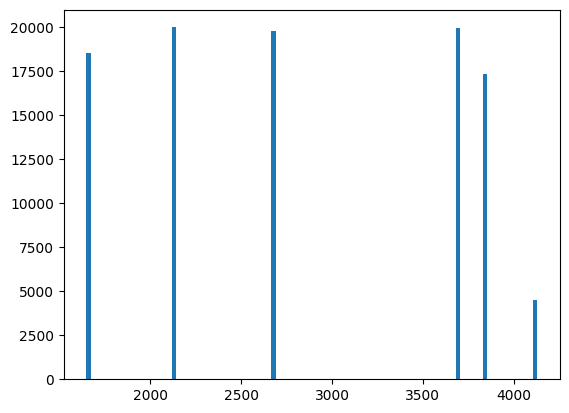

Velocity max/min: 1648.00, 4128.00
For nyquist stable (200.00 Hz), choose dx << 4.12
For nyquist stable (200.00 Hz), choose dt << 0.0025
Assuming dt=0.00018, for courant stable, choose dx >> 0.747168
Recommended dx: 1.7545177


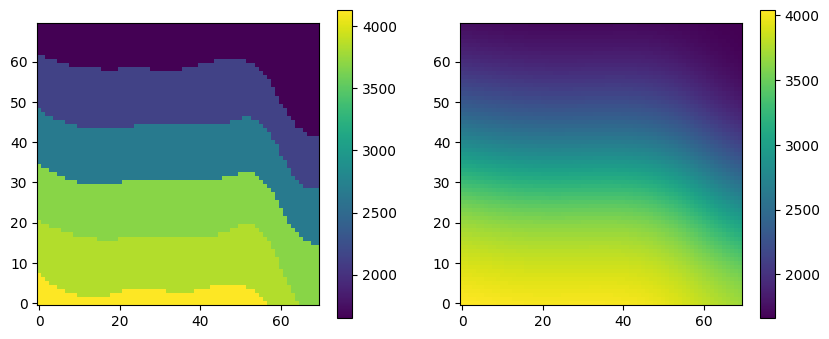

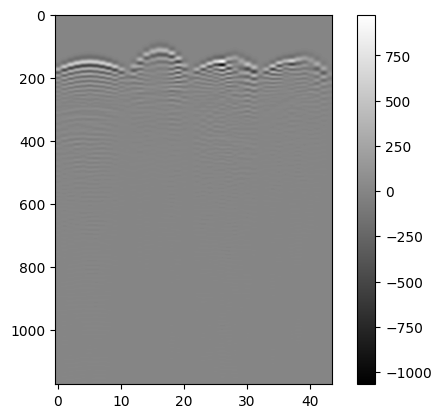

In [37]:

import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)

# get velocity models
# velocities = jnp.concatenate([jnp.load(f"../../data/CurveVelB/model/model{i+1}.npy")
#               for i in range(60)], axis=0)[:,0,::-1].transpose(0,2,1)
velocities = jnp.fliplr(jnp.load('model1.npy')[84,0,:,:].T)
v = velocities.flatten()
v = v[jax.random.randint(key, (int(1e5),), minval=0, maxval=len(v))]
plt.figure()
plt.hist(v, bins=100)
plt.show()

# run simulation
mi, ma = 1500, 4500
# velocity = 2*velocities/(ma+mi)# normalise
velocity = velocities
print_stable_simulation_parameters(velocity, f=200, dt=0.000181)
density = jnp.ones_like(velocity)*1000
source_i = [35, 45]
f0 = 200
dx = dy = 0.53
dt = 5e-5
n_steps = int(326 * 3.6)
r = jnp.arange(10,65,5)
o = jnp.ones_like(r)
receiver_is = jnp.stack([jnp.concatenate([r, r, 10*o, 60*o]),
                        jnp.concatenate([10*o, 60*o, r, r])], axis=-1)
# gather, wavefields = acoustic2D(velocity, density, source_i, f0, dx, dy, dt, n_steps, receiver_is)
gather, wavefields = acoustic2D_pml(velocity, density, source_i, f0, dx, dy, dt, n_steps, receiver_is)

# plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(velocity.T, origin="lower")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(gaussian_filter(velocity, 10).T, origin="lower")
plt.colorbar()
plt.show()

for i in range(0, n_steps, n_steps//30):
    plt.figure()
    plt.imshow(wavefields[i].T, origin="lower", cmap="bwr", vmin=-4000, vmax=4000)
    plt.colorbar()
    plt.imshow(velocity.T, origin="lower", alpha=0.2, cmap="grey")
    plt.scatter(receiver_is[:,0], receiver_is[:,1])
    # plt.show()
    plt.savefig(f"wavefield_{i}.png")
    plt.close()


plt.figure()
plt.imshow(gather, cmap="grey", aspect=0.05)
plt.colorbar()
plt.show()

In [38]:
# make a movie
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt



def make_movie():
    # make a movie
    if os.path.exists("movie"):
        shutil.rmtree("movie")
    os.makedirs("movie")

    for i in range(0, n_steps, n_steps//30):
        plt.figure()
        plt.imshow(wavefields[i].T, origin="lower", cmap="bwr", vmin=-4000, vmax=4000)
        plt.colorbar()
        plt.imshow(velocity.T, origin="lower", alpha=0.2, cmap="grey")
        plt.scatter(receiver_is[:,0], receiver_is[:,1])
        plt.savefig(f"movie/wavefield_{i:03d}.png")  # Ensure filenames are zero-padded
        plt.close()

    images = []
    for filename in sorted(glob.glob('movie/*.png'), key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1])):
        img = cv2.imread(filename)
        images.append(img)

    # save as mp4
    out = cv2.VideoWriter('movie.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (images[0].shape[1], images[0].shape[0]))
    for image in images:
        out.write(image)
    out.release()
    # remove temporary files
    shutil.rmtree("movie")
    # os.remove("movie.mp4")




In [39]:
make_movie()

In [31]:
key = jax.random.PRNGKey(0)
_, key = jax.random.split(key)

# select 1 random numbers from 0 to 20
for i in range(15):
    _, key = jax.random.split(key)
    # random_numbers = jax.random.randint(key, (1,), minval=0, maxval=20)
    random_numbers = jax.random.choice(key, 20)
    print("Random number:", random_numbers)

Random number: 0
Random number: 17
Random number: 16
Random number: 19
Random number: 12
Random number: 9
Random number: 3
Random number: 11
Random number: 11
Random number: 17
Random number: 4
Random number: 18
Random number: 1
Random number: 19
Random number: 8
